In [100]:
import boto3
import io
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
def qp_eval(x, Q, b):
    return 0.5 * x @ Q @ x + b @ x

In [133]:
# Benchmark identifier
benchmark_name = f"QP-5d"
num_instances = 10
resolution = 8
numruns = 1000
T = 1
tol = 5e-3

# S3 identifier
bucket_name = "amazon-braket-wugroup-us-east-1"

(array([670.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 330.]),
 array([-4.36883244, -4.34998618, -4.33113991, -4.31229365, -4.29344738,
        -4.27460112, -4.25575485, -4.23690859, -4.21806232, -4.19921606,
        -4.18036979]),
 <BarContainer object of 10 artists>)

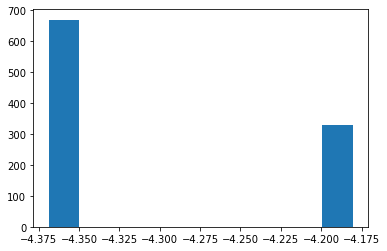

In [164]:
instance = 9

benchmark_path = os.path.join("/Users/lengjiaqi/QHD_DATA/QP", benchmark_name)
filename = f"instance_{instance}.npy"
with open(os.path.join(benchmark_path, filename), 'rb') as f:
    Q = np.load(f)
    b = np.load(f)
    Q_c = np.load(f)
    b_c = np.load(f)
n = len(Q)

# Load QCQP data
path = f"/Users/lengjiaqi/QHD_DATA/QP/{benchmark_name}"
sample_filename = f"qcqp_{instance}.npy"
#sample_filename = f"sdr_suggest_{instance}.npy"
qcqp_filename = os.path.join(path, sample_filename)
qcqp_samples = np.load(qcqp_filename)
qcqp_obj = []

for k in range(numruns):
    x_qcqp = qcqp_samples[k]
    qcqp_obj.append(qp_eval(x_qcqp, Q, b))
    
plt.hist(qcqp_obj)

In [165]:
np.mean(qcqp_obj)

-4.3066397670835626

In [28]:
post_qhd_count = np.zeros(num_instances)
dwave_qhd_count = np.zeros(num_instances)
qcqp_count = np.zeros(num_instances)

post_qhd_mean_obj = np.zeros(num_instances)
dwave_qhd_mean_obj = np.zeros(num_instances)
qcqp_mean_obj = np.zeros(num_instances)

for instance in range(num_instances):
    # Load instance data from S3
    instance_filename = f"jiaqileng/qhd/{benchmark_name}/instance_{instance}/instance_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=instance_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    Q = np.load(bytes_)
    b = np.load(bytes_)
    Q_c = np.load(bytes_)
    b_c = np.load(bytes_)

    # Load Gurobi data (ground truth)
    gurobi_filename = f"jiaqileng/qhd/{benchmark_name}/instance_{instance}/gurobi_solution_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=gurobi_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    x_best = np.load(bytes_)
    f_best = qp_eval(x_best, Q, b) 
    
    # Load post-QHD data (Advantage6)
    post_qhd_filename = f"jiaqileng/qhd/{benchmark_name}/instance_{instance}/post_advantage6_sim_rez{resolution}_T{T}_sample_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=post_qhd_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    post_qhd_samples = np.load(bytes_)
    post_qhd_obj = []
    
    # Load DWave-QHD data (Advantage6)
    dwave_qhd_filename = f"jiaqileng/qhd/{benchmark_name}/instance_{instance}/post_advantage6_qhd_rez{resolution}_T{T}_sample_{instance}.npy"
    res = boto3.client('s3').get_object(Bucket=bucket_name, Key=dwave_qhd_filename)
    bytes_ = io.BytesIO(res['Body'].read())
    dwave_qhd_samples = np.load(bytes_)
    dwave_qhd_obj = []
    
    # Load QCQP data
    path = f"/Users/lengjiaqi/LocalResearchData/qcqp_suggest/{benchmark_name}"
    sample_filename = f"qcqp_{instance}.npy"
    #sample_filename = f"sdr_suggest_{instance}.npy"
    qcqp_filename = os.path.join(path, sample_filename)
    qcqp_samples = np.load(qcqp_filename)
    qcqp_obj = []
    
     # compute objective values
    for k in range(numruns):
        x_post_qhd = post_qhd_samples[k]
        post_qhd_obj.append(qp_eval(x_post_qhd, Q, b))
        
        x_qcqp = qcqp_samples[k]
        qcqp_obj.append(qp_eval(x_qcqp, Q, b))
    
    for j in range(len(dwave_qhd_samples)):
        x_dwave_qhd = dwave_qhd_samples[j]
        dwave_qhd_obj.append(qp_eval(x_dwave_qhd, Q, b))
    
    # count success events
    # rel_tol = np.abs(f_best*tol)
    rel_tol = tol
    #best_fval_gurobi[instance] = f_best
    post_qhd_count[instance] = np.sum(np.abs(post_qhd_obj - f_best) <= rel_tol)
    dwave_qhd_count[instance] = np.sum(np.abs(dwave_qhd_obj - f_best) <= rel_tol)
    qcqp_count[instance] = np.sum(np.abs(qcqp_obj - f_best) <= rel_tol)
    
    # compute mean objective values
    post_qhd_mean_obj[instance] = np.mean(post_qhd_obj) - f_best
    dwave_qhd_mean_obj[instance] = np.mean(dwave_qhd_obj) - f_best
    qcqp_mean_obj[instance] = np.mean(qcqp_obj) - f_best
    
    print(f"Benchmark: {benchmark_name}, instance {instance}: finished.")

Benchmark: QP-3d, instance 0: finished.
Benchmark: QP-3d, instance 1: finished.
Benchmark: QP-3d, instance 2: finished.
Benchmark: QP-3d, instance 3: finished.
Benchmark: QP-3d, instance 4: finished.
Benchmark: QP-3d, instance 5: finished.
Benchmark: QP-3d, instance 6: finished.
Benchmark: QP-3d, instance 7: finished.
Benchmark: QP-3d, instance 8: finished.
Benchmark: QP-3d, instance 9: finished.


In [30]:
dwave_qhd_mean_obj

array([-7.10542736e-15,  8.88625592e-03,  4.86482103e-02,  0.00000000e+00,
        7.10542736e-15,  3.55271368e-15,  1.77635684e-15, -7.10542736e-15,
       -3.55271368e-15,  0.00000000e+00])

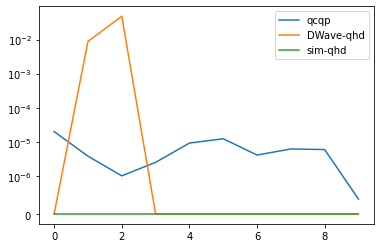

In [32]:
plt.plot(qcqp_mean_obj, label='qcqp')
plt.plot(dwave_qhd_mean_obj, label='DWave-qhd')
plt.plot(post_qhd_mean_obj, label='sim-qhd')
plt.yscale('symlog', linthresh=1e-6)
plt.legend()